In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Goal
The goal of this side project is to use Gaussian processes to estimate a data
marker, given only the time. Gaussian process is an alternative to regression
problems where instead of knowing the specific function and the parameters, we
find a distribution over the possible functions that are consistent with observed
data. 

### About the data
In the following data set I have a total of 50 markers on a body
suite. Each subject traces a specific line 5 times, these get saved into x, y and
z coordinates. The c if positive means that the recording is useful, otherwise it is not. 

# Data exploration

In [55]:
Data = pd.read_csv("20161207111143-59968-right-speed_0.500.csv")
print(Data.shape)
Data.head()

(1030, 211)


,frame,elapsed_time,target_x,target_y,target_z,finger_x,finger_y,finger_z,head_x,head_y,...,47_z,47_c,48_x,48_y,48_z,48_c,49_x,49_y,49_z,49_c
0,0,0.021849,-0.285367,1.508715,-1.397246,-0.309010,1.488178,-1.407305,-0.776337,1.453431,...,-0.977498,3.896204,-0.895035,0.066168,-1.068119,4.000000,-0.744605,0.049483,-1.065959,3.214167
1,1,0.032913,-0.287563,1.509291,-1.403424,-0.307350,1.489949,-1.409069,-0.774965,1.454609,...,-0.977725,4.000000,-0.894199,0.067299,-1.069162,3.625534,-0.743797,0.049996,-1.066073,4.000000
2,2,0.043974,-0.287488,1.509131,-1.404539,-0.306001,1.491764,-1.410137,-0.773850,1.454972,...,-0.977740,4.000000,-0.892940,0.068681,-1.070695,4.094944,-0.742623,0.050470,-1.065952,4.000000
3,3,0.054993,-0.287739,1.508501,-1.405519,-0.304244,1.493510,-1.411431,-0.773634,1.454301,...,-0.977967,3.806175,-0.892225,0.070506,-1.072590,4.000000,-0.741425,0.050943,-1.065629,3.191848
4,4,0.066056,-0.288231,1.508622,-1.406108,-0.302070,1.495173,-1.412526,-0.772007,1.455343,...,-0.978211,4.000000,-0.891714,0.072109,-1.073936,3.736544,-0.740082,0.051399,-1.065960,4.000000


### Choose a marker to explore

In [85]:
time = Data['elapsed_time'].values
X_pos = Data['3_x'].values

In [86]:
len(time)

1030

In [87]:
len(X_pos)

1030

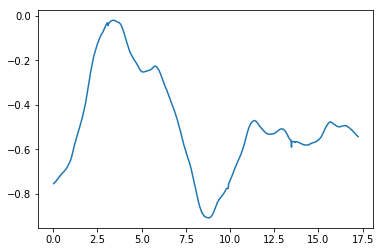

In [88]:
plt.plot(time,X_pos)

In [89]:
len(Data[Data['3_c']<0])

0

All of the marker values in 3 are useful 

# Functions needed for optimization

### The kernel Q not including the identity 

In [91]:
def kernel_k(sigma,t):
    #sigma = [sigma_f,sigma_l,sigma_n]    
    n = len(t)    
    k = np.zeros((n,n))    
    for i in range(n):
        for j in range(n):
            k[i,j] = np.exp(sigma[0])*np.exp((-1/2)*np.exp(sigma[1])*(t[i]-t[j])**2)
    return k

### The derivative of kernel Q with respect to the hyper parameters

In [92]:
def dQ_sigma_l_fun(sigma,t):
    #sigma = [sigma_f,sigma_l,sigma_n]    
    n = len(t)    
    dk_sig = np.zeros((n,n))    
    for i in range(n):
        for j in range(n):
            dk_sig[i,j] = np.exp(sigma[0])*np.exp((-1/2)*np.exp(sigma[1])*(t[i]-t[j])**2)*((-1/2)*np.exp(sigma[1])*(t[i]-t[j])**2)
    return dk_sig

### The log likelyhood function of the data

In [93]:
def likely(sigma,t,y):
    
    k = kernel_k(sigma,t) 
    Kernel = k + np.exp(sigma[2])*np.identity(len(t))   
    Q = Kernel 
    Q_inv = np.linalg.inv(Q)
    alpha = np.matmul(Q_inv,y)    
    alpha = alpha.reshape((1,-1))   
    
    likely_log = -(1/2)*(np.matmul(alpha,y.reshape((1,-1)).transpose())-np.log(np.linalg.norm(Q)))
    #first term is data fit term and second represents the model complexity. 
    #Both are considered of value in the optimization problem. 
    
    return likely_log[0] 

### The derivative of the log likelyhood functions with respect to the hyper parameters

In [94]:
def grad(sigma,t,y):
    
    k = kernel_k(sigma,t)
    Kernel = k    
    Q = Kernel + sigma[2]**2*np.identity(len(t))  
    Q_inv = np.linalg.inv(Q)
    alpha = np.matmul(Q_inv,y)    
    alpha = alpha.reshape((1,-1))   
    Inner_K = np.matmul(alpha.transpose(),alpha)-Q_inv
    
    dFun_dsigma_f = (1/2)*np.trace(np.matmul(Inner_K,k)) 
    dQ_dsigma_l =  dQ_sigma_l_fun(sigma,t)   
    dFun_dsigma_l = (1/2)*np.trace(np.matmul(Inner_K,dQ_dsigma_l))
    dQ_dsigma_n = 2*sigma[2]*np.identity(len(t))
    dFun_dsigma_n = (1/2)*np.trace(np.matmul(Inner_K,dQ_dsigma_n))
    
    Fun_grad = np.array([dFun_dsigma_f,dFun_dsigma_l,dFun_dsigma_n])
    return Fun_grad    

### Steepest ascent function to find hyper parameters

In [119]:
def steep_des(sigma_0,t,y,gamma=np.array([0.005,0.005,1e-5]),stop_eps=1e-6,stop_iter=1e3):
    #[0.005,0.0005,1e-6]
    iter_n = 0
    likely_fun = np.zeros(int(stop_iter)+1)    
    sigma = sigma_0
    Fun_grad = grad(sigma,t,y)
    likely_fun[0] = likely(sigma,t,y)
    
    
    while np.linalg.norm(Fun_grad)>stop_eps and iter_n<stop_iter:
        
        sigma = sigma + np.multiply(gamma,Fun_grad)
        Fun_grad = grad(sigma,t,y)
        iter_n +=1
        likely_fun[iter_n] = likely(sigma,t,y)
        
    print('norm of the gradient: ',np.linalg.norm(Fun_grad))   
    print('number of itertions: ',iter_n) 
    return [sigma,likely_fun]

# Maximizing log likelyhood function with respect to the hyper parameters

### Initial conditions, found from inspection

In [108]:
#initial values hyper parameters
sigma_0 = np.array([-1.81607294,  0.02871432,  0.33192521])

In [103]:
t = time[0::25]
y = X_pos[0::25]
t_prim = time[0::5]

Text(0,0.5,'x position for 3rd marker')

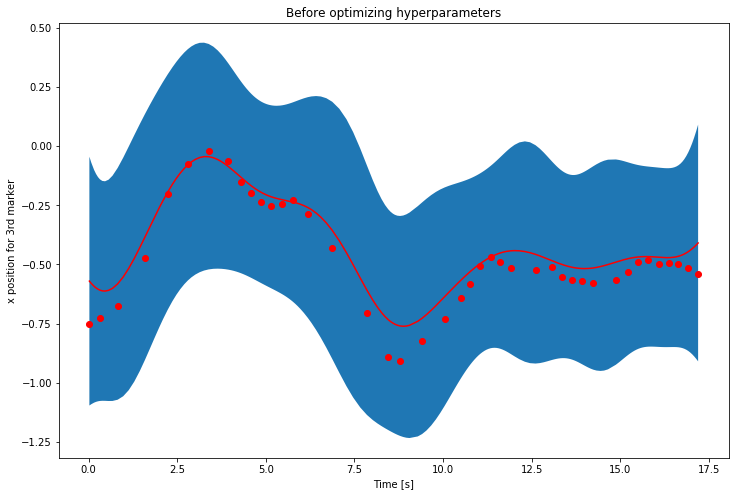

In [115]:
K = kernel(sigma_0,t,t) + sigma_0[2]**2*np.identity(len(t)) 
k_star = kernel(sigma_0,t,t_prim)
k_star_star = kernel(sigma_0,t_prim,t_prim)

K_inv = np.linalg.inv(K)
K_inv_y = np.matmul(K_inv,y)

mean = np.matmul(k_star.transpose(),K_inv_y)

K_inv_k_star = np.matmul(K_inv,k_star)
Cov = k_star_star - np.matmul(k_star.transpose(),K_inv_k_star)

Cov_diag = Cov.diagonal()
upper = mean + 2.575*np.sqrt(Cov_diag)
lower = mean - 2.575*np.sqrt(Cov_diag)

plt.figure(figsize=(12,8))
plt.plot(time[0::25],X_pos[0::25],'ro')
plt.plot(t_prim,mean,'r')
plt.fill_between(t_prim,lower,upper)
plt.title('Before optimizing hyperparameters')
plt.xlabel('Time [s]')
plt.ylabel('x position for 3rd marker')

### Optimize hyperparameters using steepest ascent

In [120]:
sigma_likely = steep_des(sigma_0,time[0::25],X_pos[0::25])
sigma = sigma_likely[0]
print(sigma)

norm of the gradient:  9.92312997813e-07
number of itertions:  806
[-1.50735021 -1.24587703  0.01942581]


Text(0,0.5,'x position for 3rd marker')

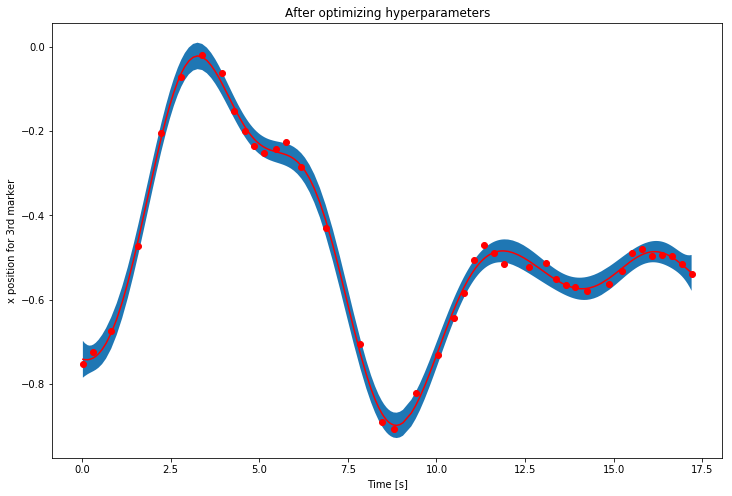

In [122]:
K = kernel(sigma,t,t) + sigma[2]**2*np.identity(len(t)) 
k_star = kernel(sigma,t,t_prim)
k_star_star = kernel(sigma,t_prim,t_prim)

K_inv = np.linalg.inv(K)
K_inv_y = np.matmul(K_inv,y)

mean = np.matmul(k_star.transpose(),K_inv_y)

K_inv_k_star = np.matmul(K_inv,k_star)
Cov = k_star_star - np.matmul(k_star.transpose(),K_inv_k_star)

Cov_diag = Cov.diagonal()
upper = mean + 2.575*np.sqrt(Cov_diag)
lower = mean - 2.575*np.sqrt(Cov_diag)

plt.figure(figsize=(12,8))
plt.plot(time[0::25],X_pos[0::25],'ro')
plt.plot(t_prim,mean,'r')
plt.fill_between(t_prim,lower,upper)
plt.title('After optimizing hyperparameters')
plt.xlabel('Time [s]')
plt.ylabel('x position for 3rd marker')

# Conclusions

I seeked to maximize a likelihood function with respect to hyperparameters. This was done through gradient 
ascent. Since gradient ascent is a local optimization method, it is very sensitive to initial
conditions and step-size. I varied both to try to find the most optimal solution.
However, my optimal hyperparameters still show quite a lot of noise. One way
to get rid of this could be by cleaning the data a bit.